In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt

# Zobrazí všechna sloupce
pd.set_option('display.max_columns', None)

# Zobrazí všechny řádky
pd.set_option('display.max_rows', None)

In [2]:
import pandas as pd

# Načtěte data
df = pd.read_excel('../data/europe/data_europe.xlsx')

# Zkontrolujte názvy sloupců
print(df.columns)

# Případně odstraňte bílé znaky kolem názvů sloupců
df.columns = df.columns.str.strip()

# Pokud je sloupec 'University ↓ / Student →' přítomen, přejmenujte ho na 'origin'
df = df.rename(columns={'University ↓ / Student →': 'origin'}).melt(id_vars='origin', var_name='destination', value_name='value')

# Zobrazte prvních několik řádků
df.tail()

Index(['University ↓ / Student →', 'Belgium', 'Bulgaria', 'Czechia', 'Denmark',
       'Germany', 'Estonia', 'Ireland', 'Greece', 'Spain', 'France', 'Croatia',
       'Italy', 'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary',
       'Malta', 'Netherlands', 'Austria', 'Poland', 'Portugal', 'Slovakia',
       'Finland', 'Slovenia', 'Romania', 'Sweden', 'Iceland', 'Liechtenstein',
       'Norway', 'Switzerland', 'United Kingdom', 'Bosnia and Herzegovina',
       'Montenegro', 'Moldova', 'North Macedonia', 'Georgia', 'Albania',
       'Serbia', 'Türkiye', 'Ukraine', 'Kosovo*', 'Andorra', 'Belarus',
       'Gibraltar', 'Holy See', 'Monaco', 'Russia', 'San Marino'],
      dtype='object')


,origin,destination,value
1857,Montenegro,San Marino,0
1858,North Macedonia,San Marino,0
1859,Albania,San Marino,0
1860,Serbia,San Marino,0
1861,Türkiye,San Marino,0


In [3]:
# Load spatial regions
gdf = gpd.read_file('../data/europe/CNTR_RG_01M_2024_3035.gpkg')

# Keep only necessary columns and compute centroids
gdf = gdf[['NAME_ENGL', 'geometry']]

# Compute centroids
gdf['centroid'] = gdf.geometry.centroid

# Show the result
gdf.head()

,NAME_ENGL,geometry,centroid
0,Ilemi Triangle,"MULTIPOLYGON (((7391633.521 -1433654.651, 7392...",POINT (7306723.89 -1451848.519)
1,Andorra,"POLYGON ((3627760.953 2188194.002, 3627277.391...",POINT (3628457.533 2198764.45)
2,United Arab Emirates,"MULTIPOLYGON (((8767105.237 1705081.232, 87679...",POINT (8711031.949 1387327.726)
3,Afghanistan,"POLYGON ((9034788.364 3786148.688, 9037836.72 ...",POINT (9048203.505 3046373.991)
4,Antigua and Barbuda,"MULTIPOLYGON (((-2523559.791 2859842.723, -252...",POINT (-2549756.507 2817227.084)


In [4]:
# Merge centroids for origin and destination
df_with_centroids = df.merge(gdf[['NAME_ENGL', 'centroid']], left_on='origin', right_on='NAME_ENGL', how='left').rename(columns={'centroid': 'centroid_origin'}).drop(columns='NAME_ENGL')
df_with_centroids = df_with_centroids.merge(gdf[['NAME_ENGL', 'centroid']], left_on='destination', right_on='NAME_ENGL', how='left').rename(columns={'centroid': 'centroid_destination'}).drop(columns='NAME_ENGL')

# Filter valid rows (positive flow values and non-null centroids)
df_valid_flows = df_with_centroids[(df_with_centroids['value'] > 0) & df_with_centroids['centroid_origin'].notnull() & df_with_centroids['centroid_destination'].notnull()]

# Create flow lines based on centroids
df_valid_flows['geometry'] = df_valid_flows.apply(lambda row: LineString([row['centroid_origin'], row['centroid_destination']]), axis=1)

# Convert to GeoDataFrame
gdf_flows = gpd.GeoDataFrame(df_valid_flows[['geometry', 'value']], geometry='geometry', crs=gdf.crs)

# Weight the flow lines based on value
gdf_flows['weight'] = gdf_flows['value'] / gdf_flows['value'].max() * 20

# Show the result
gdf_flows.head()


C:\Users\michal\AppData\Local\Temp\ipykernel_4168\2120982408.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_flows['geometry'] = df_valid_flows.apply(lambda row: LineString([row['centroid_origin'], row['centroid_destination']]), axis=1)


,geometry,value,weight
1,"LINESTRING (5561605.534 2310144.94, 3944211.8 ...",28,0.014322
2,"LINESTRING (4705416.597 2973007.636, 3944211.8...",38,0.019436
3,"LINESTRING (4325324.337 3649824.892, 3944211.8...",230,0.117641
4,"LINESTRING (4347032.196 3104643.52, 3944211.8 ...",3089,1.579970
5,"LINESTRING (5216266.896 4050563.729, 3944211.8...",13,0.006649


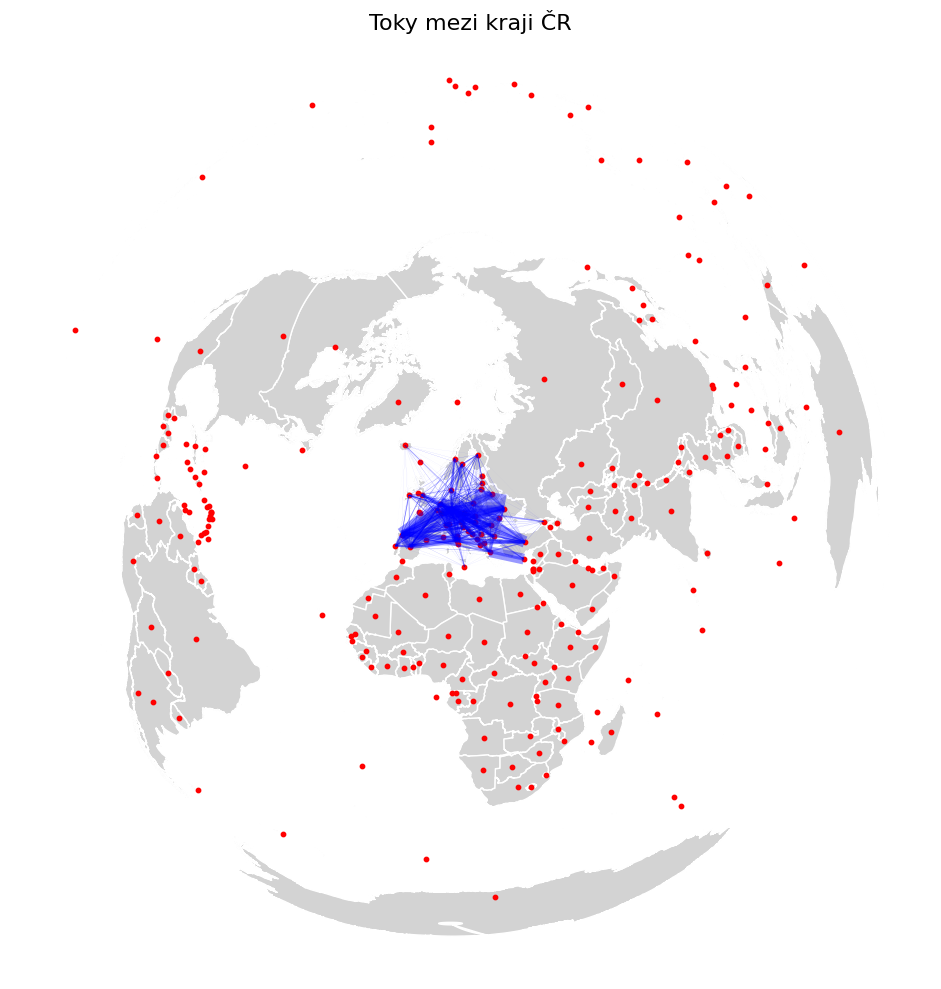

In [5]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot regions, flows, and centroids
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf_flows.plot(ax=ax, linewidth=gdf_flows['weight'], color='blue', alpha=0.4)
gdf.set_geometry('centroid').plot(ax=ax, color='red', markersize=10)

# Set plot title and remove axis
ax.set_title("Toky mezi kraji ČR", fontsize=16)
ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [6]:
# Uložení do GeoPackage
gdf_flows_clean.to_file("../data/czech/student_flows.gpkg", layer="flows", driver="GPKG")

NameError: name 'gdf_flows_clean' is not defined